In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

parent_path, current_path =  os.path.split(os.getcwd())
data_path = os.path.join(parent_path, "Data")
sys.path.append(parent_path)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging as logger
from scipy import stats
import category_encoders as ce

from src.preprocess import date_process, read_csv
from src.transformer import ConTransform, CatHandlerHighCard

from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error, r2_score,
                             roc_auc_score)

pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

In [4]:
import os

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras

import lifetime_value as ltv

# Preprocessing Functions

In [5]:
total_df = read_csv(os.path.join(data_path, "train_data.csv"))
test_df = read_csv(os.path.join(data_path, "test_data.csv"))
total_df['full_cat'] = total_df[["cat1", "cat2", "cat3"]].agg('-'.join, axis=1)

In [6]:
train_df, dev_df  = train_test_split(total_df, test_size=0.2)

In [7]:
transformer_list = [
            ( "net_price", ConTransform()),
            ( "num1", ConTransform()),
            ( "num2", ConTransform()),
            ( "num3", ConTransform()),
            ( "num4", ConTransform()),
            ( "num5", ConTransform()),
            ( "num6", ConTransform()),
            ( "cat1", CatHandlerHighCard(threshold=30)),
            ( "cat2", CatHandlerHighCard(threshold=30)),
            ( "cat3", CatHandlerHighCard(threshold=30)),
            ( "weekday",CatHandlerHighCard(threshold=30))
            ]

In [8]:
dev_list = list()
train_list = list()
for key, transformer in transformer_list:
    transformer.fit(train_df[key])
    train_list.append(transformer.transform(train_df[key]))
    dev_list.append(transformer.transform(dev_df[key]))
train_feature = pd.concat(train_list,1)
dev_feature = pd.concat(dev_list,1)

In [9]:
dev_y = dev_df.net_revenue.reset_index(drop=True)
dev_binary_y = dev_df.purchase.reset_index(drop=True)
train_y = train_df.net_revenue.reset_index(drop=True)

In [10]:
train_feature.shape

(135344, 1546)

In [11]:
def dnn_model():
    deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(3),
    ])
    return deep_model

loss = ltv.zero_inflated_lognormal_loss
model = dnn_model()
model.compile(loss=loss, optimizer=keras.optimizers.Adam(lr=1e-5))

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

history = model.fit(
    x=train_feature,
    y=train_y,
    batch_size=1024,
    epochs=100,
    verbose=2,
    callbacks=callbacks,
    validation_data=(dev_feature, dev_y)).history

Epoch 1/100
133/133 - 4s - loss: 0.8898 - val_loss: 0.8559
Epoch 2/100
133/133 - 1s - loss: 0.8690 - val_loss: 0.8357
Epoch 3/100
133/133 - 2s - loss: 0.8479 - val_loss: 0.8149
Epoch 4/100
133/133 - 1s - loss: 0.8262 - val_loss: 0.7935
Epoch 5/100
133/133 - 2s - loss: 0.8040 - val_loss: 0.7715
Epoch 6/100
133/133 - 1s - loss: 0.7813 - val_loss: 0.7490
Epoch 7/100
133/133 - 1s - loss: 0.7581 - val_loss: 0.7260
Epoch 8/100
133/133 - 1s - loss: 0.7344 - val_loss: 0.7025
Epoch 9/100
133/133 - 1s - loss: 0.7104 - val_loss: 0.6788
Epoch 10/100
133/133 - 1s - loss: 0.6863 - val_loss: 0.6549
Epoch 11/100
133/133 - 1s - loss: 0.6619 - val_loss: 0.6307
Epoch 12/100
133/133 - 1s - loss: 0.6373 - val_loss: 0.6064
Epoch 13/100
133/133 - 1s - loss: 0.6128 - val_loss: 0.5822
Epoch 14/100
133/133 - 1s - loss: 0.5883 - val_loss: 0.5581
Epoch 15/100
133/133 - 1s - loss: 0.5639 - val_loss: 0.5340
Epoch 16/100
133/133 - 2s - loss: 0.5396 - val_loss: 0.5101
Epoch 17/100
133/133 - 1s - loss: 0.5155 - val_lo

<AxesSubplot:>

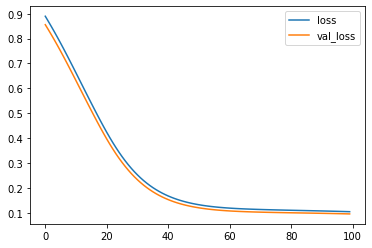

In [12]:
pd.DataFrame(history)[['loss', 'val_loss']][:].plot()

In [13]:
def get_probs(logits: tf.Tensor) -> tf.Tensor:
    logits = tf.convert_to_tensor(logits, dtype=tf.float32)
    positive_probs = tf.keras.backend.sigmoid(logits[..., :1])
    return positive_probs

In [14]:
logits = model.predict(x=dev_feature, batch_size=1024)
probs = get_probs(logits).numpy().flatten()
y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

In [15]:
roc_auc_score(y_true=dev_binary_y, y_score=probs)

0.6855328707759885

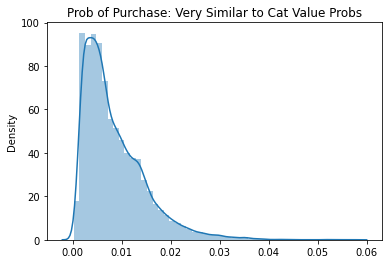

In [16]:
plt.title("Prob of Purchase: Very Similar to Cat Value Probs")
sns.distplot(probs)
plt.show()

In [17]:
r2_score(y_true=dev_y,
                              y_pred=y_pred)

-0.1259445375388013

In [18]:
mean_absolute_percentage_error(y_true=dev_y,
                              y_pred=y_pred)

1.669153084297222e+16

In [19]:
mean_absolute_error(y_true=dev_y,
                              y_pred=y_pred)

4.590917616958352

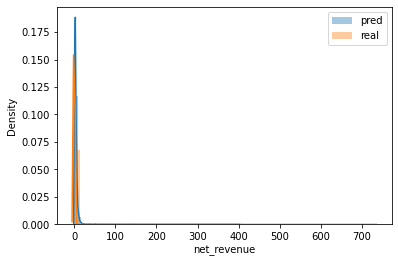

In [22]:
sns.distplot(y_pred,label="pred")
sns.distplot(dev_y, label="real")
plt.legend()

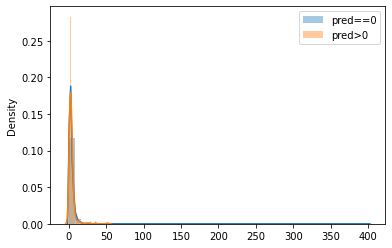

In [23]:
sns.distplot(y_pred[dev_y==0],label="pred==0")
sns.distplot(y_pred[dev_y>0], label="pred>0")
plt.legend()

In [26]:
stats.pearsonr(y_pred, dev_y)[0]

0.02128027131193528

# Test Prediction

In [28]:
test_df = read_csv(os.path.join(data_path, "test_data.csv"))

In [29]:
feature_list = list()
for key, transformer in transformer_list:
    feature_list.append(transformer.transform(test_df[key]))
test_feature = pd.concat(feature_list, 1)

In [35]:
logits = model.predict(x=test_feature, batch_size=1024)
test_prediction_df = pd.DataFrame({
    "prediction": ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()}
)

In [ ]:
test_prediction_df.to_csv("Deep_test_prediction.csv", index=False)

Text(0.5, 1.0, 'Prediction Distribution')

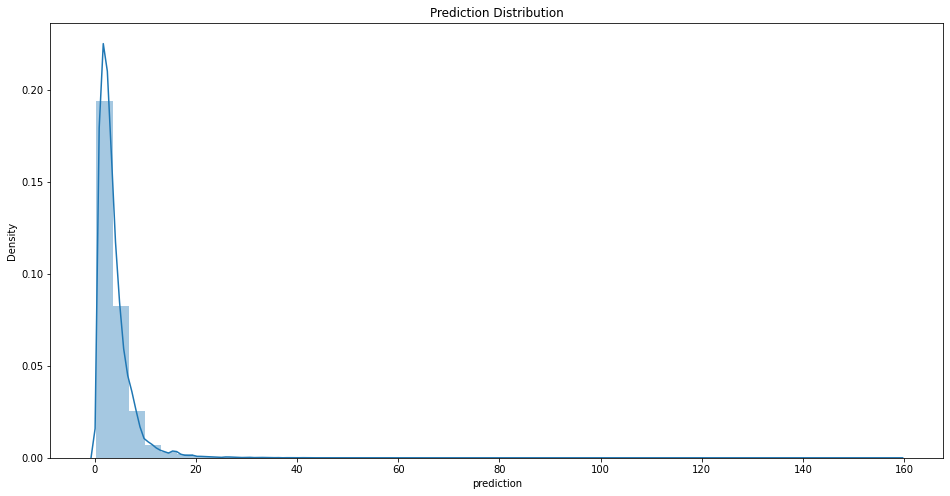

In [40]:
plt.figure(figsize=(16,8))
sns.distplot(test_prediction_df.prediction)
plt.title("Prediction Distribution")

# Closer to original dist.